## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [26]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import numpy as np
import time
# import os
import random
import matplotlib.pyplot as plt
# from matplotlib import colors
from PIL import Image as Image
from tqdm import tqdm
# from sklearn.metrics import roc_auc_score

In [2]:
# Install and import the MedMNIST package and datasets.

# !pip install medmnist
import medmnist

## Some information from the dataset

You can browse the imaging datasets on their webpage https://medmnist.com/, and download them as such:

You can find relevant information about the datasets in the info.INFO dictionary.


In [3]:
# Some information about dataset

data_flag = 'bloodmnist'                # Dataset choosen
download = True                         # Download dataset (optional)

info = medmnist.INFO[data_flag]         # Extract dataset info (dictionary container)
task =          info['task']            # Classification task:  multi-class, reggresion, binary, ...
n_channels =    info['n_channels']      # Color/gray scale images
labels =        info['label']           # Extract class labels
n_classes =     len(labels)     

print(info)     

# Partial display of information in info
print("Medmnist class: "      , info['python_class'])   #  Medmnist dataset type:   BloodMNIST, ChestMNIST, DermaMNIST, ....
print("Url: "                 , info['url'])            #  Url dir
print("Classification task: " , info['task'])           #  Classification tasks:   
print("Class labels: "        , info['label'])          #  Class labels
print("Samples: "             , info['n_samples'])      #  Samples subdatasets

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

In [4]:
# Define dataclass instance medmnist.dataset.Bloodmnist
DataClass = getattr(medmnist, info['python_class'])  

# Load datasets
train_dataset   = DataClass(split='train', size= 28, download= download)
val_dataset     = DataClass(split='val'  , size= 28, download= download)
test_dataset    = DataClass(split='test' , size= 28, download= download) 

Using downloaded and verified file: C:\Users\felix\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\felix\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\felix\.medmnist\bloodmnist.npz


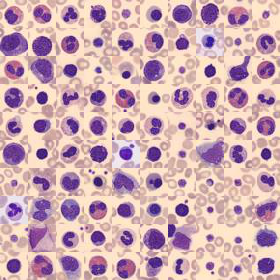

In [5]:
# Visualize some train images
train_dataset.montage(length=10)

## Pre-processing

In [8]:
# Standarization and normalization  ([0,1])

train   , _    = norm_n_stand_dataset(train_dataset)
val     , _    = norm_n_stand_dataset(val_dataset  )
test    , _    = norm_n_stand_dataset(test_dataset )

## Generate a dataloader

A convinient option for accessing data in torch is with the use of the Dataloader class. These work directly when given a MNIST dataset as input.
You can also apply any necesary preprocesing steps directly as you load the data with the Transforms package and the transform MNIST argument.

Choose apropiate values for the training hiperparameters (you can experiment with sampling strategies if you want) and implement the adecuate preprocesing steps. Finally, choose an Mnist dataset and create the dataloader for the training, validation and test splits.

In [160]:
# Parameters
NUM_EPOCHS = 10         # cuántas veces el algoritmo de aprendizaje ha trabajado a través de todo el conjunto de datos de entrenamiento
BATCH_SIZE = 200       # verá BATCH_SIZE ejemplos antes de hacer una actualización de los pesos del modelo.
lr = 0.0001            # learning rate   

im_size = train_dataset.size
in_channels = train_dataset.info['n_channels']
num_classes = len( train_dataset.info['label'] )

# Load and preprocess data
# Your code
train_loader = data.DataLoader(dataset= train , batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset= val   , batch_size=BATCH_SIZE, shuffle=False)
test_loader  = data.DataLoader(dataset= test  , batch_size=BATCH_SIZE, shuffle=False)

## Create a deep learning model

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Definir la arquitectura de la red neuronal
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)  # 10 clases en BloodMNIST

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)

# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

# Evaluación del modelo
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        test_acc = 100.0 * correct / total
        print(f'Test Accuracy: {test_acc:.2f}%')

# Entrenar y evaluar el modelo
train(model, train_loader, criterion, optimizer, num_epochs=5)
evaluate(model, test_loader)


ValueError: too many values to unpack (expected 2)

#Train Model

Implement the main traning loop to train the deep learning model.
This should include the forward and backward passes. You can find information about how to do this with torch in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id14

In [ ]:
# Train the model

for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize

        #Your code


#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [ ]:
# Evaluation

# Your code


## Anexo

##### Cálculo de balanceo de muestras

In [143]:

def samples_per_class(dataset, show_balance= False):
    '''
        Parameter:
            dataset         :  (img, label) array or list
            show_balance    :   True; prints the number of samples per class (label) .

        Returns:
            An array containing the number of samples per class in the specified 'dataset'.
    '''
    labels = set()
    samples = []
    counter = []
    
    for img, label in dataset:
        if not isinstance(label, int):  # assume size 1 container 
            label = label.item() 
        
        labels.add(label)

        # Cheking if 
        if label >= max(labels) and  max(labels) > len(samples)-1: 
            for i in range(max(labels) - len(samples)+1 ):
                samples.append( [] ) 
                counter.append( [0] )

        samples[label].extend([img])
        counter[label][0] += 1
            
    # Print balance
    if show_balance:
        for i in range(n_classes):
            print(f"Clase: {i}, Cantidad de imágenes: {counter[i]}")

    return samples, counter

In [144]:
# -- Example of use:

# Sample balancing control by class
samples, val = samples_per_class(train_dataset, show_balance= True) 
print( "Some '0' labeled images: ", samples[0])

Clase: 0, Cantidad de imágenes: [852]
Clase: 1, Cantidad de imágenes: [2181]
Clase: 2, Cantidad de imágenes: [1085]
Clase: 3, Cantidad de imágenes: [2026]
Clase: 4, Cantidad de imágenes: [849]
Clase: 5, Cantidad de imágenes: [993]
Clase: 6, Cantidad de imágenes: [2330]
Clase: 7, Cantidad de imágenes: [1643]
Some '0' labeled images:  [<PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA1030>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA1630>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA0BB0>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA2B30>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA09D0>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA1750>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA3DC0>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA31C0>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B8EAA1510>, <PIL.Image.Image image mode=RGB size=28x28 at 0x20B080F93F0>, <PIL.Image.Image image mode=RGB size=28x28 a

In [157]:
def _extract_n_samples(dataset, n_samples):
    '''
        This function...

        Parameters:
            dataflag    :   MedMNIST string dataset identificator, i.e 'bloodmnist', 'breastmnist'.
            dataset     :   MedMNIST subdataset, i.e medmnist.dataset.bloodmnist
            n_samples   :   Number of samples to be taken

        Constraints:
            n_samples < len(dataset)

        Returns:
            Returns an array of size n_samples containing image-label pairs. 
            The number of samples of each class is proportional to the number 
            of samples they were in 'dataset'.
    '''
    assert(n_samples <= len(dataset.imgs))   # Check size constraint
    
    out = []   # Store final dataset

    # Obtain: Samples (imgs) per class, Number of samples per class (per label)
    samples, nsamples_per_class = samples_per_class(dataset, show_balance= False)  
    total = np.sum(nsamples_per_class)  

    # Number of images proportional to the original dataset
    prop_samples = np.round( ( np.array(nsamples_per_class) * n_samples) / total ).astype(int) 

    # Store
    for i in range( len(samples) ) :
        out.extend( [ (e, i) for e in random.sample(samples[i], prop_samples[i][0]) ] )

    # Shuffle 
    np.random.shuffle(out)

    return out


new_dataset = _extract_n_samples(train_dataset, 1000)

In [158]:
# ---------------
# Application example:

new_dataset = _extract_n_samples(train_dataset, 1000)
print(len(new_dataset))
# Check new class sample balance
balance = samples_per_class2(new_dataset, True)
print( balance )

999
{0, 1, 2, 3, 4, 5, 6, 7}
Clase: 0, Cantidad de imágenes: [71]
Clase: 1, Cantidad de imágenes: [182]
Clase: 2, Cantidad de imágenes: [91]
Clase: 3, Cantidad de imágenes: [169]
Clase: 4, Cantidad de imágenes: [71]
Clase: 5, Cantidad de imágenes: [83]
Clase: 6, Cantidad de imágenes: [195]
Clase: 7, Cantidad de imágenes: [137]
None


In [42]:
a = []
a.extend([(1,'a'),(2,'b'),(3,'c')])
print(a)
a.extend([(4,'d'),(5,'e'),(6,'f')])
print(a)

[(1, 'a'), (2, 'b'), (3, 'c')]
[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f')]


In [126]:
idx = np.argsort(train_dataset.labels)
print(idx.flatten())
print(train_dataset.labels)


# Usar los índices para ordenar el ndarray
ordered = (train_dataset.imgs[idx], train_dataset.labels[idx])
# print(train_dataset[5000])

[0]
[[7]
 [3]
 [6]
 ...
 [1]
 [6]
 [4]]


Índices ordenados:
[1 2 0 3]


##### Pre-processing function


In [6]:
def norm_n_stand_dataset(dataset, debug= False):
    '''
        Normalizes and standardizes a MedMNIST dataset
        
        Parameters:
            dataset : MedMNIST split subdataset, i.e train dataset of medmnist.dataset.bloodmnist
            debug   : 'True' val prints some image mean and std to verify standarization correctness

        Return:
            norm_n_stand_tensor     : normalize and standarized 'dataset' torch tensor
            norm_n_stand_dataset    : normalize and standarized 'dataset' ndarray
    '''

    # Convert images to tensor and permute shape to handle
    tensor = torch.tensor( dataset.imgs ).permute(0, 3, 1, 2)      # (n_imgs, height, weigth, channels) --> (n_imgs, channels, height, weigth)  

    # Normalization
    max_datatype_value = torch.iinfo( tensor.dtype ).max * 1.0   # extract maximum image datatype value for normalisation 
    norm_tensor = tensor / max_datatype_value

    # Calculate the mean and standard deviation for each channel.
    mean = torch.mean(norm_tensor, dim= (2, 3), keepdim= True).float().half()    # type float16
    std  = torch.std (norm_tensor, dim= (2, 3), keepdim= True).float().half()    # type float16

    # Standardization
    norm_n_stand_tensor = ( norm_tensor - mean ) / std

    # Permute to the original shape (before conversion to tensor)  
    norm_n_stand_dataset = norm_n_stand_tensor.permute(0, 2, 3, 1).numpy()                # Uncomment if needed

    # Check the correctness of the standardisation
    if debug:
        meanc = torch.mean(norm_n_stand_tensor, dim= (2, 3), keepdim= True)
        stdc  = torch.std (norm_n_stand_tensor, dim= (2, 3), keepdim= True)

        print("Checking mean and std correctness\n")
        print(meanc, stdc)
        # info output: Each 3-tuple consists of (R,G,B) channels' means and standard deviations.

    return norm_n_stand_tensor, norm_n_stand_dataset